In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import os
import numpy as np
import json
import cv2

import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import webcolors

from minimal.dataset import FloorplanGraphDataset
from minimal.utils import draw_plan
from highlevel.lib import generate_plan_v2, LayoutGraph, NodeType, _make_edge_triplets

%matplotlib inline

In [25]:
sample = next(iter(FloorplanGraphDataset()))

In [27]:
_, nds, eds = sample

In [46]:
nodes = torch.where(nds == 1)[1].tolist()
print(nodes)

[4, 2, 2, 3, 1, 0, 16, 16, 16, 16, 16, 14]


In [76]:
edges = [(a, b) for a, x, b in eds.tolist() if x == 1]
print(edges)

[(0, 5), (0, 7), (1, 5), (1, 6), (2, 5), (2, 8), (3, 5), (3, 9), (4, 5), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11)]


In [61]:
g = LayoutGraph(nodes, edges)

In [74]:
masks = generate_plan_v2(g, num_iters=25)

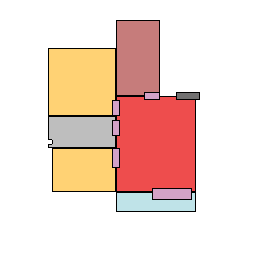

In [75]:
draw_plan(masks, nodes)

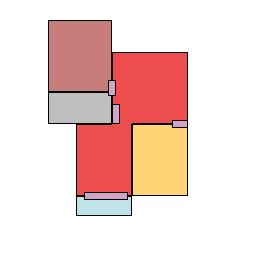

In [71]:
draw_plan(masks, nodes)

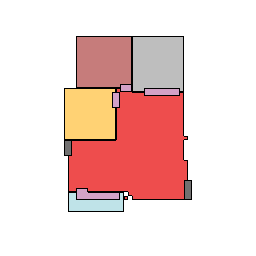

In [69]:
draw_plan(masks, nodes)